In [1]:
import pymongo
import json
import pandas as pd
from datetime import datetime, timedelta
from pandas import DataFrame
import matplotlib.pyplot as plt
from datetime import time
from tqdm import tqdm

from sklearn.neighbors import NearestNeighbors
import numpy as np
from math import *
from shapely.geometry import Point, Polygon
import geopandas as gpd
import sys
print(sys.path)
import math
from tqdm import tqdm
from pandas import DataFrame
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from kneed import KneeLocator
from sklearn.neighbors import NearestNeighbors, KDTree
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

/opt/anaconda3/envs/finding_insights_data/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


['/Users/ohidabinteamin/Documents/Stress Prediction Project Three Datasets/StudentLife/week 01/Location', '/opt/anaconda3/envs/finding_insights_data/lib/python39.zip', '/opt/anaconda3/envs/finding_insights_data/lib/python3.9', '/opt/anaconda3/envs/finding_insights_data/lib/python3.9/lib-dynload', '', '/opt/anaconda3/envs/finding_insights_data/lib/python3.9/site-packages']


In [2]:
myclient = pymongo.MongoClient("mongodb://localhost:27017/")
mydb = myclient["studentlife"]

In [3]:
student_uid = ['u00', 'u01', 'u02', 'u03', 'u04', 'u05', 'u07', 'u08', 'u09', 'u10', 'u12', 'u13', 'u14', 'u15', 'u16',
                'u17', 'u18', 'u19', 'u20', 'u22', 'u23', 'u24', 'u25', 'u27', 'u30', 'u31', 'u32', 'u33', 'u34', 'u35',
                'u36', 'u39', 'u41', 'u42', 'u43', 'u44', 'u45', 'u46', 'u47', 'u49', 'u50', 'u51', 'u52', 'u53', 'u54',
                'u56', 'u57', 'u58', 'u59']

In [4]:
df_gps = mydb.gps
df_gps = DataFrame(list(df_gps.find()))
df_gps = df_gps.drop("_id", axis=1)
df_gps

,provider,network_type,accuracy,latitude,longitude,altitude,bearing,speed,travelstate,uid,timestamp
0,network,wifi,22.094,43.7066051,-72.2870424,0.0,0.0,0.0,,u45,1364410654
1,network,wifi,24.652,43.7065982,-72.2870054,0.0,0.0,0.0,,u45,1364411866
2,network,wifi,24.06,43.706614,-72.2870392,0.0,0.0,0.0,,u45,1364852743
3,network,wifi,25.242,43.7066032,-72.2870255,0.0,0.0,0.0,,u45,1364853942
4,gps,,14.0,43.70714984,-72.2865919,199.399993896,0.0,0.559017,,u45,1364854001
...,...,...,...,...,...,...,...,...,...,...,...
202872,network,wifi,20.0,43.7051446,-72.2893337,0.0,0.0,0.0,stationary,u49,1370057807
202873,network,wifi,110.806,43.7051051,-72.2892419,0.0,0.0,0.0,stationary,u49,1370058153
202874,network,wifi,20.374,43.7051571,-72.2892962,0.0,0.0,0.0,stationary,u49,1370058408
202875,network,wifi,27.674,43.7051066,-72.2892418,0.0,0.0,0.0,stationary,u49,1370058753


In [5]:
df_gps['timestamp'] = pd.to_datetime(df_gps['timestamp'], unit='s')
df_gps['date'] = df_gps['timestamp'].dt.strftime('%Y-%m-%d')
df_gps['timestamp'] = df_gps['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')

In [6]:
morning_start_time = time(6, 0, 0)     # 6:00 AM
afternoon_start_time = time(12, 0, 0)  # 12:00 PM
evening_start_time = time(18, 0, 0)    # 6:00 PM
night_start_time = time(0, 0, 0)       # 12:00 AM (midnight)

df_gps['timestamp'] = pd.to_datetime(df_gps['timestamp'])
df_gps['time'] = df_gps['timestamp'].dt.time

def categorize_time_interval(timestamp):
    current_time = timestamp.time()
    
    if morning_start_time <= current_time < afternoon_start_time:
        return "morning"
    elif afternoon_start_time <= current_time < evening_start_time:
        return "afternoon"
    elif evening_start_time <= current_time <= time(23, 59, 59):
        return "evening"
    else:
        return "night"

df_gps['time_interval'] = df_gps['timestamp'].apply(categorize_time_interval)
df_gps = df_gps.drop("time", axis=1)
df_gps.head(3)

,provider,network_type,accuracy,latitude,longitude,altitude,bearing,speed,travelstate,uid,timestamp,date,time_interval
0,network,wifi,22.094,43.7066051,-72.2870424,0.0,0.0,0.0,,u45,2013-03-27 18:57:34,2013-03-27,evening
1,network,wifi,24.652,43.7065982,-72.2870054,0.0,0.0,0.0,,u45,2013-03-27 19:17:46,2013-03-27,evening
2,network,wifi,24.06,43.706614,-72.2870392,0.0,0.0,0.0,,u45,2013-04-01 21:45:43,2013-04-01,evening


In [7]:
print(df_gps['time_interval'].value_counts())
print(len(df_gps['uid'].unique()))

morning      51198
night        51182
afternoon    50305
evening      50192
Name: time_interval, dtype: int64
49


In [8]:
df = df_gps.sort_values(['uid', 'date', 'timestamp'])
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

In [9]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # radius of earth in kilometers
    return c * r

In [10]:
def calculate_group_distances(group):
    group['shifted_lon'] = group['longitude'].shift(-1)
    group['shifted_lat'] = group['latitude'].shift(-1)
    group['time_diff'] = abs(group['timestamp'].diff(-1).dt.total_seconds())
    group['distance'] = group.apply(
        lambda row: haversine(row['longitude'], row['latitude'], row['shifted_lon'], row['shifted_lat'])
        if pd.notna(row['shifted_lon']) and pd.notna(row['shifted_lat']) else 0,
        axis=1
    )
    group['speed'] = group['distance'] / (group['time_diff'] / 3600)
    return group

df['latitude'] = pd.to_numeric(df['latitude'])
df['longitude'] = pd.to_numeric(df['longitude'])
df = df.groupby(['uid', 'date', 'time_interval']).apply(calculate_group_distances)

/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/870325293.py:15: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df = df.groupby(['uid', 'date', 'time_interval']).apply(calculate_group_distances)


In [11]:
result_1 = df.groupby(['uid', 'date', 'time_interval']).agg(
    total_distance=('distance', 'sum'),
    max_distance=('distance', 'max'),
    var_distance=('distance', 'var'),
    mean_speed=('speed', 'mean'),
    speed_variance=('speed', 'var')
).reset_index()

In [12]:
print(result_1.head(3))

   uid        date time_interval  total_distance  max_distance  var_distance  \
0  u00  2013-03-27     afternoon        2.363740      0.709984      0.054115   
1  u00  2013-03-27       evening       12.407804      7.902156      3.462948   
2  u00  2013-03-27       morning       49.997372     21.510659     40.386801   

   mean_speed  speed_variance  
0    0.413447        0.486441  
1    2.190630       32.843113  
2    8.615854      317.769064  


In [13]:
pivot_df = result_1.pivot_table(index=['uid', 'date'], columns='time_interval', values=['total_distance', 'max_distance', 'var_distance', 'mean_speed', 'speed_variance'], aggfunc='first', fill_value=0)

pivot_df.columns = [f'{stat}_{interval}' for stat, interval in pivot_df.columns]
pivot_df.reset_index(inplace=True)

print(pivot_df.columns)
pivot_df.head(3)

Index(['uid', 'date', 'max_distance_afternoon', 'max_distance_evening',
       'max_distance_morning', 'max_distance_night', 'mean_speed_afternoon',
       'mean_speed_evening', 'mean_speed_morning', 'mean_speed_night',
       'speed_variance_afternoon', 'speed_variance_evening',
       'speed_variance_morning', 'speed_variance_night',
       'total_distance_afternoon', 'total_distance_evening',
       'total_distance_morning', 'total_distance_night',
       'var_distance_afternoon', 'var_distance_evening',
       'var_distance_morning', 'var_distance_night'],
      dtype='object')


,uid,date,max_distance_afternoon,max_distance_evening,max_distance_morning,max_distance_night,mean_speed_afternoon,mean_speed_evening,mean_speed_morning,mean_speed_night,...,speed_variance_morning,speed_variance_night,total_distance_afternoon,total_distance_evening,total_distance_morning,total_distance_night,var_distance_afternoon,var_distance_evening,var_distance_morning,var_distance_night
0,u00,2013-03-27,0.709984,7.902156,21.510659,0.044694,0.413447,2.190630,8.615854,0.053758,...,317.769064,0.005366,2.363740,12.407804,49.997372,0.089609,0.054115,3.462948,40.386801,0.000530
1,u00,2013-03-28,0.615331,0.572584,13.829300,21.510630,0.407571,0.162931,19.148841,11.210838,...,391.695778,448.782099,2.311922,0.923275,82.978312,63.566695,0.038126,0.019999,43.084070,47.781932
2,u00,2013-03-29,0.783514,0.658679,7.915113,21.510646,0.494983,23.340963,5.434347,12.662640,...,84.115085,458.376628,2.803027,2.952871,32.898169,69.796044,0.055555,0.052738,13.379794,49.701048


In [14]:
print(result_1['total_distance'].max())
print(result_1['max_distance'].max())
print(result_1['var_distance'].max())

4122.932090389908
4120.799515732822
1886532.6241757267


In [15]:
df['latitude'], df['longitude'] = np.radians(df['latitude']), np.radians(df['longitude'])
earth_radius = 6371

In [16]:
def haversine(x):
    return (1.0 - math.cos(x)) / 2.0

def spherical_polygon_area(lats, lons, r):
    n = len(lats)
    if n != len(lons):
        raise ValueError("Latitude and Longitude arrays must have the same length.")
    
    sum_excess = 0
    for j in range(n):
        k = (j + 1) % n
        beta1, beta2 = lats[j], lats[k]
        lam1, lam2 = lons[j], lons[k]
        cosB1, cosB2 = math.cos(beta1), math.cos(beta2)
        
        if lam1 != lam2:
            hav = haversine(beta2 - beta1) + cosB1 * cosB2 * haversine(lam2 - lam1)
            a = 2 * math.asin(math.sqrt(hav))
            b = math.pi / 2 - beta2
            c = math.pi / 2 - beta1
            s = 0.5 * (a + b + c)
            t = math.tan(s / 2) * math.tan((s - a) / 2) * math.tan((s - b) / 2) * math.tan((s - c) / 2)
            
            excess = math.atan(math.sqrt(abs(t))) * 4
            if lam2 < lam1:
                excess = -excess
            
            sum_excess += excess

    return abs(sum_excess) * r * r

In [17]:
df_grouped = df.groupby(['uid', 'date', 'time_interval'])
result_2 = df_grouped.apply(lambda g: spherical_polygon_area(g['latitude'].tolist(), g['longitude'].tolist(), earth_radius))
result_2 = result_2.reset_index(name='area_convex_hull')
print(result_2)

       uid        date time_interval  area_convex_hull
0      u00  2013-03-27     afternoon          0.063416
1      u00  2013-03-27       evening          7.475047
2      u00  2013-03-27       morning         15.992131
3      u00  2013-03-27         night          0.012788
4      u00  2013-03-28     afternoon          0.004838
...    ...         ...           ...               ...
10510  u59  2013-05-31     afternoon          0.224575
10511  u59  2013-05-31       evening      10524.816583
10512  u59  2013-05-31       morning          0.086265
10513  u59  2013-05-31         night          0.020627
10514  u59  2013-06-01         night         30.418875

[10515 rows x 4 columns]


In [18]:
print(result_2['area_convex_hull'].mean())
print(result_2['area_convex_hull'].max())
print(result_2['area_convex_hull'].min())

18.25969571917248
45503.40200557608
0.0


In [19]:
pivot_df_ = result_2.pivot_table(index=['uid', 'date'], columns='time_interval', values=['area_convex_hull'], aggfunc='first', fill_value=0)

pivot_df_.columns = [f'{stat}_{interval}' for stat, interval in pivot_df_.columns]
pivot_df_.reset_index(inplace=True)

print(pivot_df_.columns)
pivot_df_.head(3)

Index(['uid', 'date', 'area_convex_hull_afternoon', 'area_convex_hull_evening',
       'area_convex_hull_morning', 'area_convex_hull_night'],
      dtype='object')


,uid,date,area_convex_hull_afternoon,area_convex_hull_evening,area_convex_hull_morning,area_convex_hull_night
0,u00,2013-03-27,0.063416,7.475047,15.992131,0.012788
1,u00,2013-03-28,0.004838,0.030363,0.000000,15.698134
2,u00,2013-03-29,0.102290,0.079619,0.101639,14.948689


In [20]:
participants = df['uid'].unique()
df['timestamp'] = pd.to_datetime(df['timestamp'])
# finding home for the hours between 8pm and 8am
df_ = df[(df['timestamp'].dt.hour >= 20) | (df['timestamp'].dt.hour < 8)]
df_

,provider,network_type,accuracy,latitude,longitude,altitude,bearing,speed,travelstate,uid,timestamp,date,time_interval,shifted_lon,shifted_lat,time_diff,distance
156575,network,wifi,24.0,0.763741,-1.262383,0.0,0.0,0.136238,stationary,u00,2013-03-27 04:02:43,2013-03-27,night,-72.329018,43.759503,1181.0,0.044694
156576,gps,,22.0,0.763747,-1.262380,250.899993896,0.0,0.131726,,u00,2013-03-27 04:22:24,2013-03-27,night,-72.329238,43.759134,1220.0,0.044640
156577,network,wifi,23.0,0.763741,-1.262383,0.0,0.0,0.000559,stationary,u00,2013-03-27 04:42:44,2013-03-27,night,-72.329240,43.759135,1199.0,0.000186
156578,network,wifi,25.0,0.763741,-1.262383,0.0,0.0,0.000000,stationary,u00,2013-03-27 05:02:43,2013-03-27,night,-72.329240,43.759135,1200.0,0.000000
156579,network,wifi,25.0,0.763741,-1.262383,0.0,0.0,0.000267,stationary,u00,2013-03-27 05:22:43,2013-03-27,night,-72.329239,43.759135,1200.0,0.000089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198955,network,wifi,22.0,0.714089,-1.287914,0.0,0.0,0.023533,stationary,u59,2013-06-01 03:17:08,2013-06-01,night,-73.792047,40.914236,599.0,0.003916
198956,network,wifi,36.0,0.714088,-1.287914,0.0,0.0,0.013469,stationary,u59,2013-06-01 03:27:07,2013-06-01,night,-73.792028,40.914250,600.0,0.002245
198957,network,wifi,39.0,0.714088,-1.287914,0.0,0.0,0.010744,stationary,u59,2013-06-01 03:37:07,2013-06-01,night,-73.792007,40.914247,600.0,0.001791
198958,network,wifi,39.0,0.714088,-1.287913,0.0,0.0,0.027474,stationary,u59,2013-06-01 03:47:07,2013-06-01,night,-73.791962,40.914270,601.0,0.004587


k-distance graph for participant u00


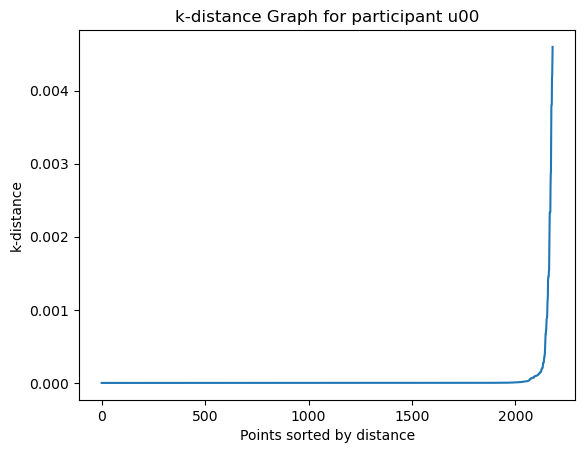

k-distance graph for participant u01


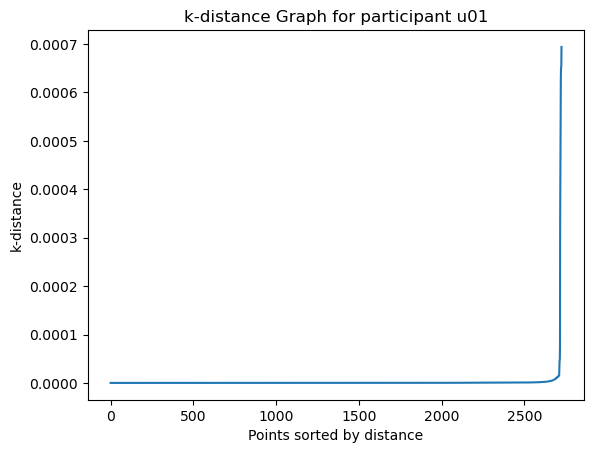

k-distance graph for participant u02


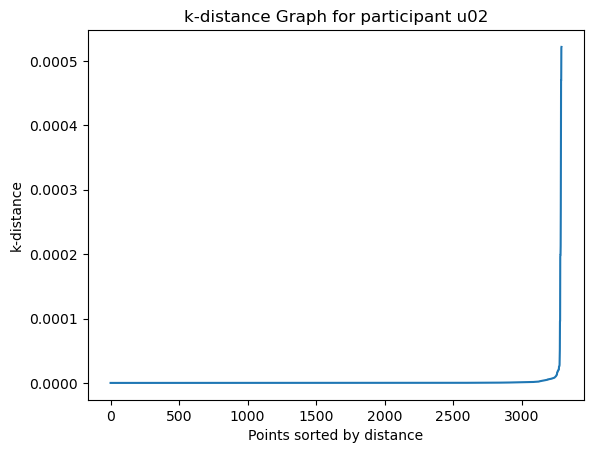

k-distance graph for participant u03


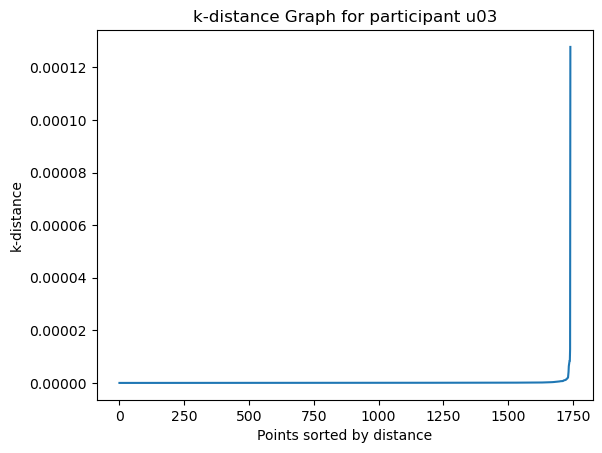

k-distance graph for participant u04


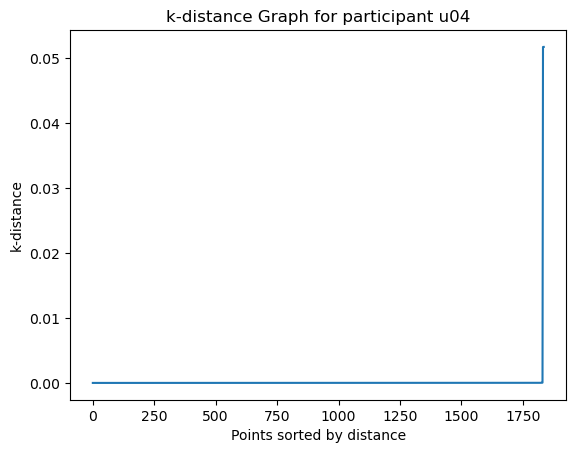

k-distance graph for participant u05


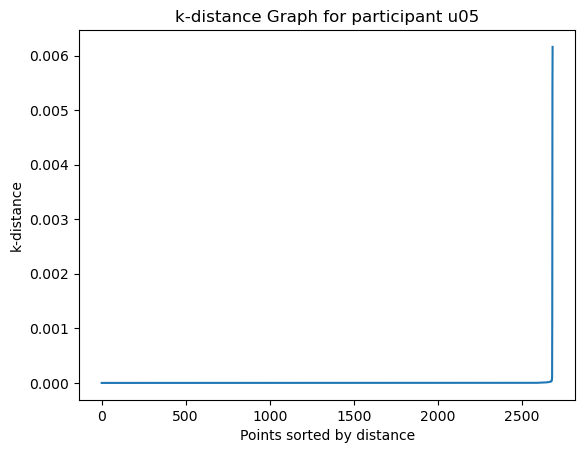

k-distance graph for participant u07


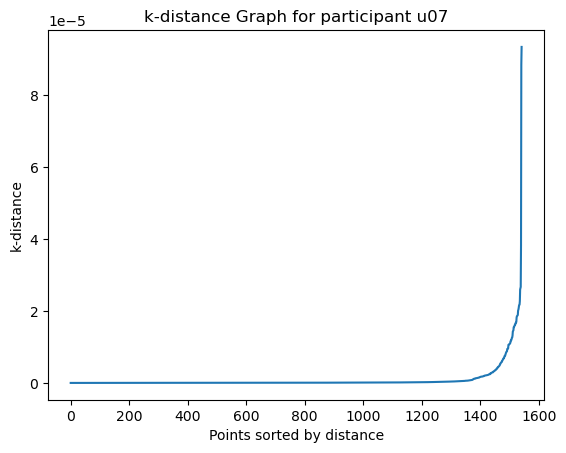

k-distance graph for participant u08


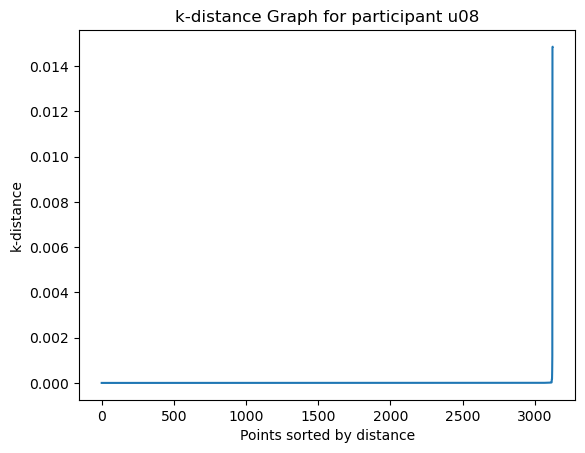

k-distance graph for participant u09


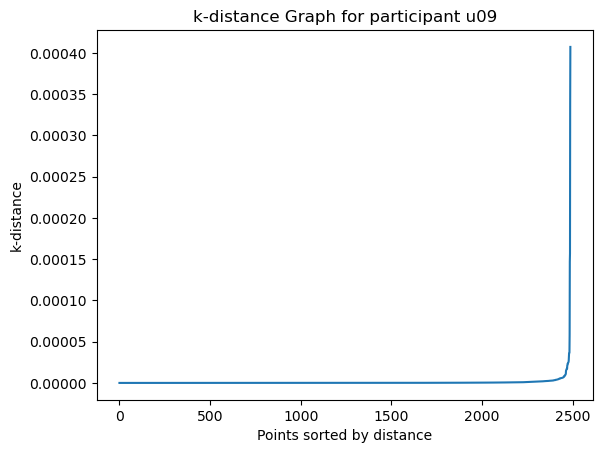

k-distance graph for participant u10


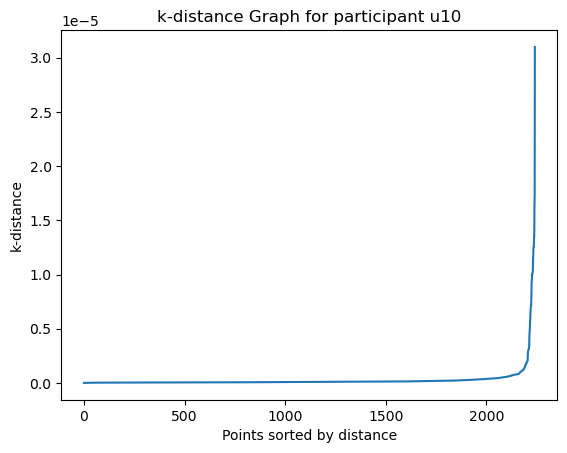

k-distance graph for participant u12


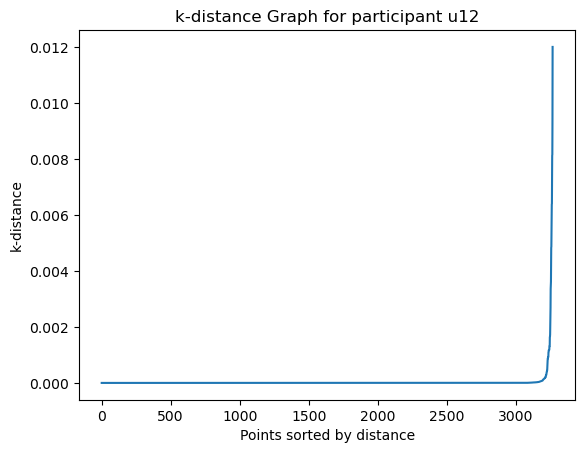

k-distance graph for participant u13


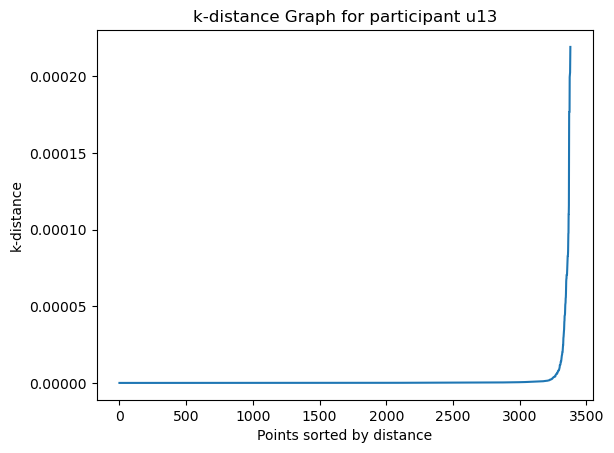

k-distance graph for participant u14


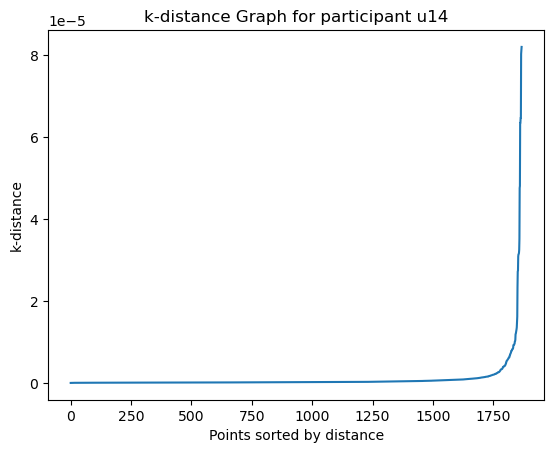

k-distance graph for participant u15


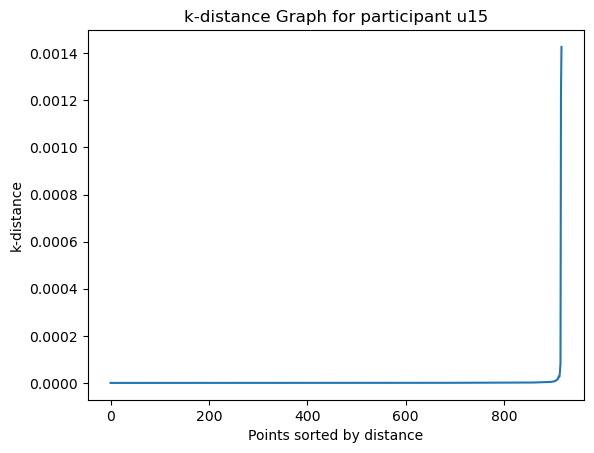

k-distance graph for participant u16


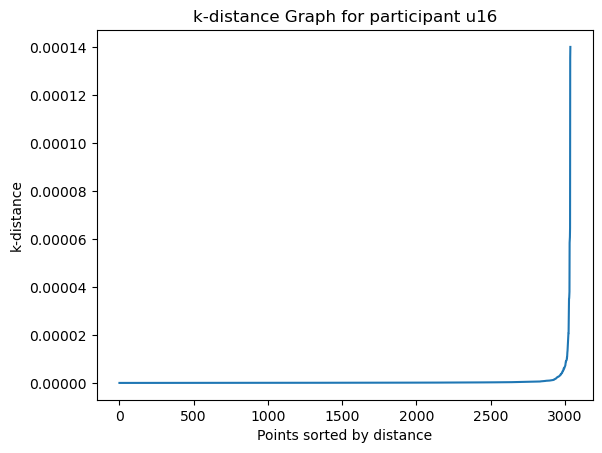

k-distance graph for participant u17


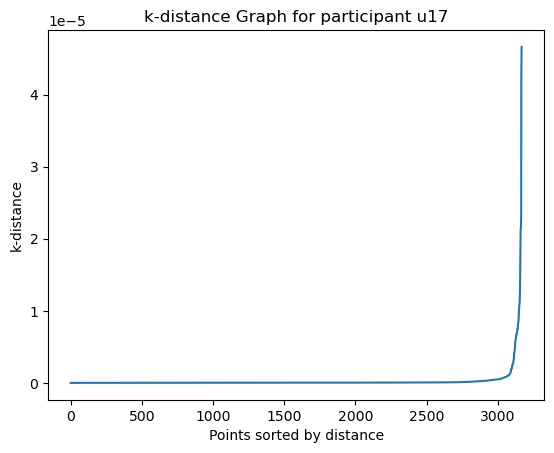

k-distance graph for participant u18


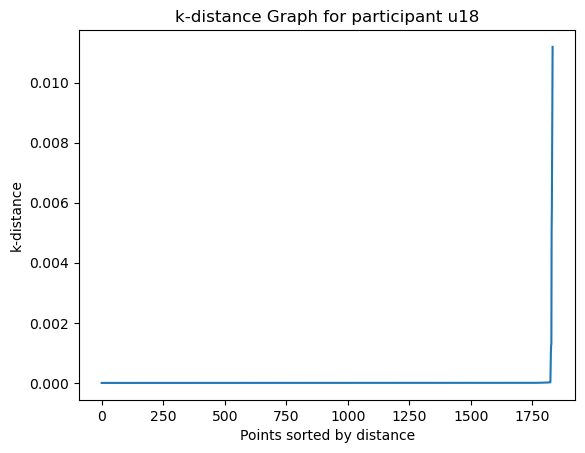

k-distance graph for participant u19


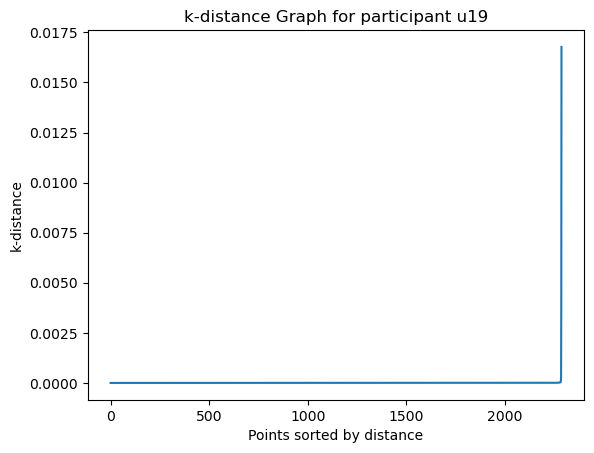

k-distance graph for participant u20


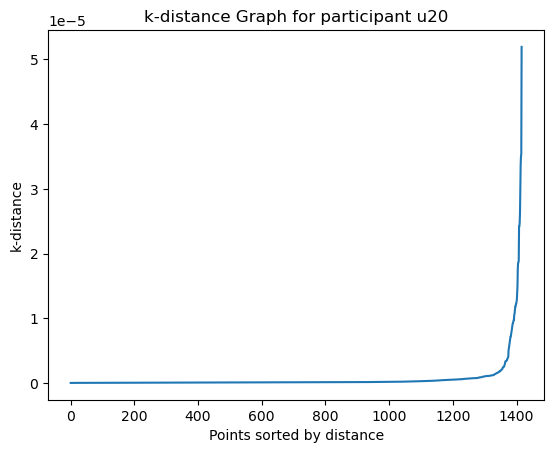

k-distance graph for participant u22


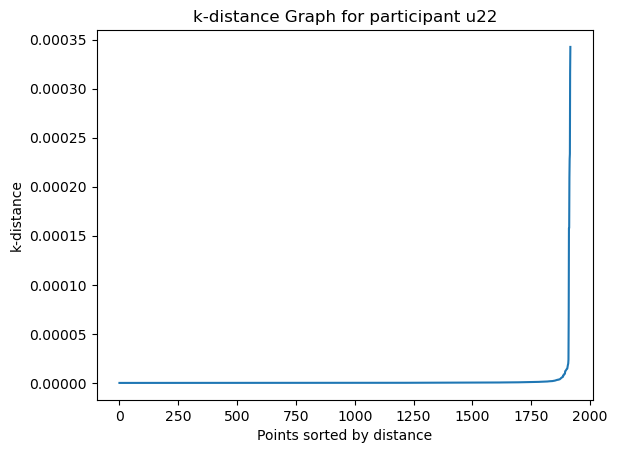

k-distance graph for participant u23


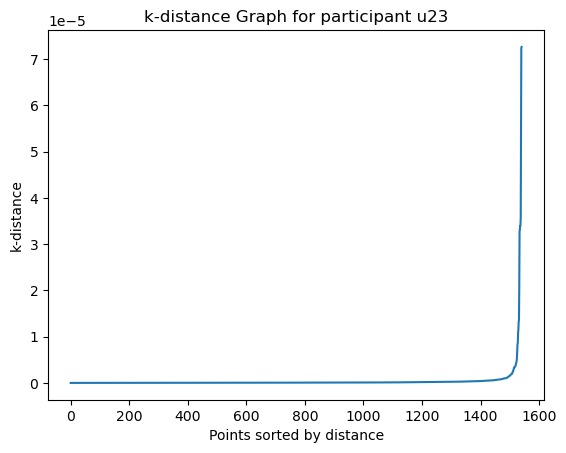

k-distance graph for participant u24


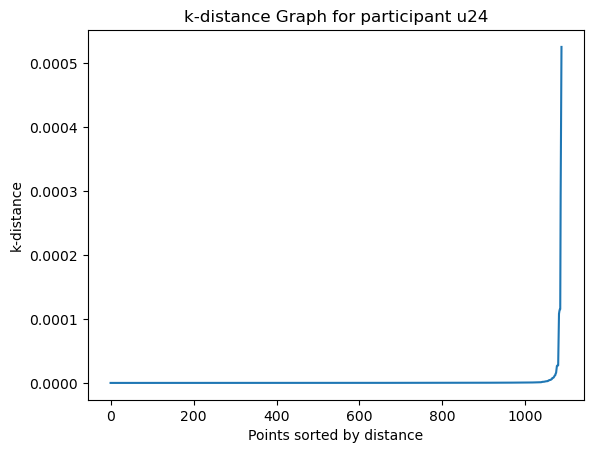

k-distance graph for participant u25


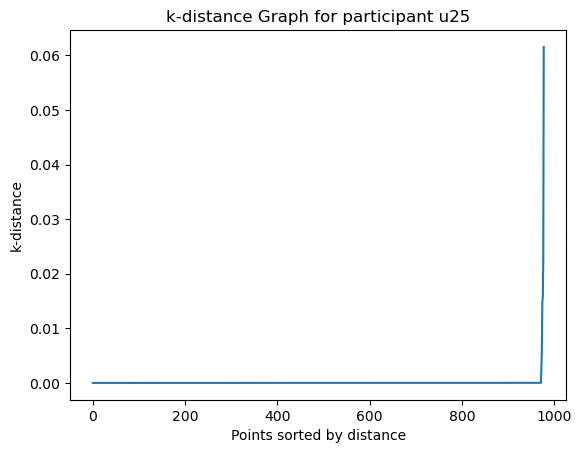

k-distance graph for participant u27


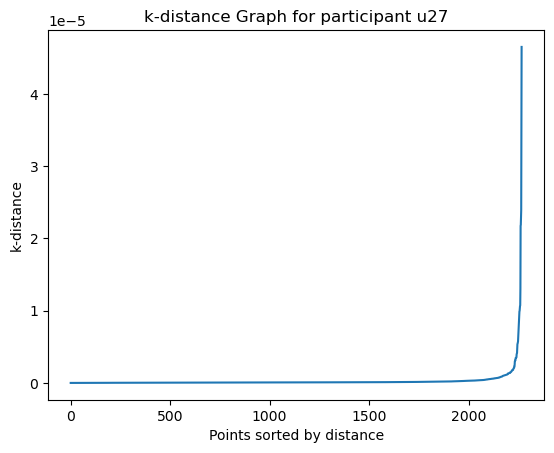

k-distance graph for participant u30


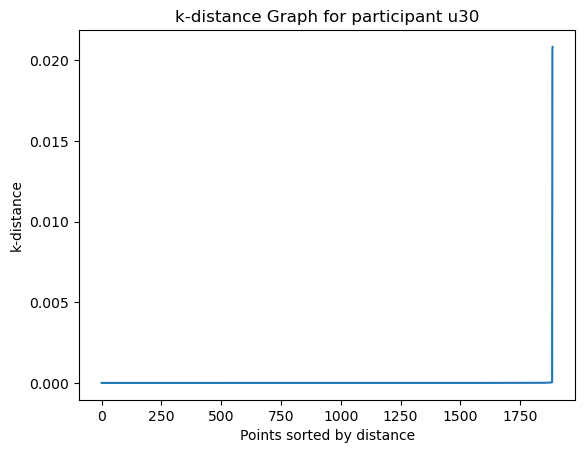

k-distance graph for participant u31


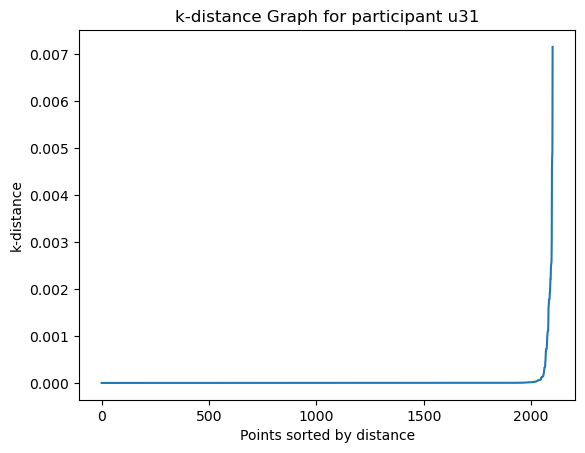

k-distance graph for participant u32


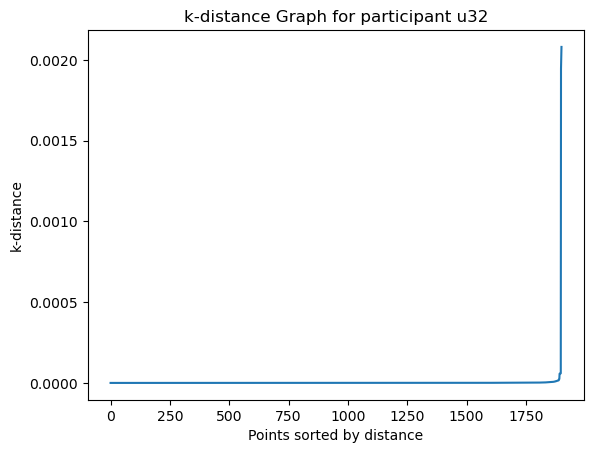

k-distance graph for participant u33


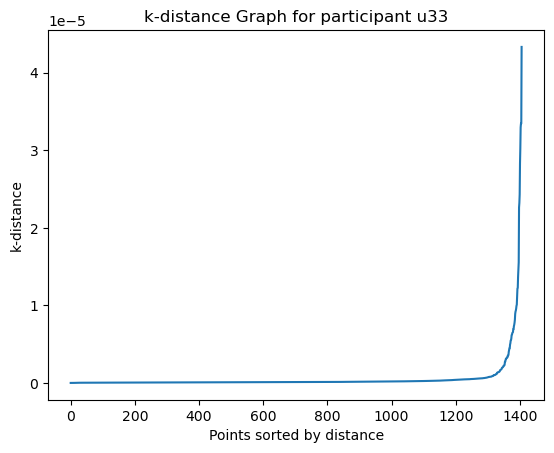

k-distance graph for participant u34


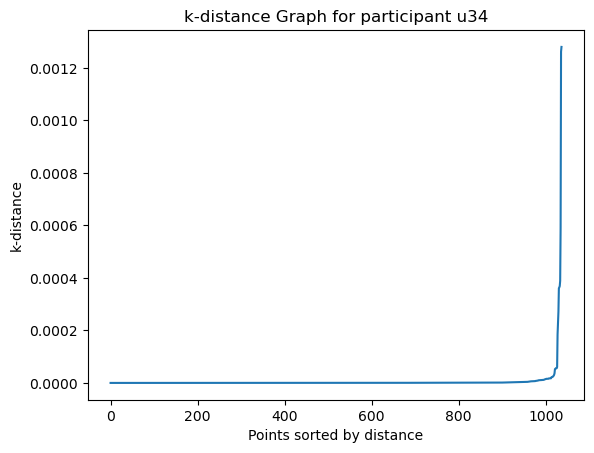

k-distance graph for participant u35


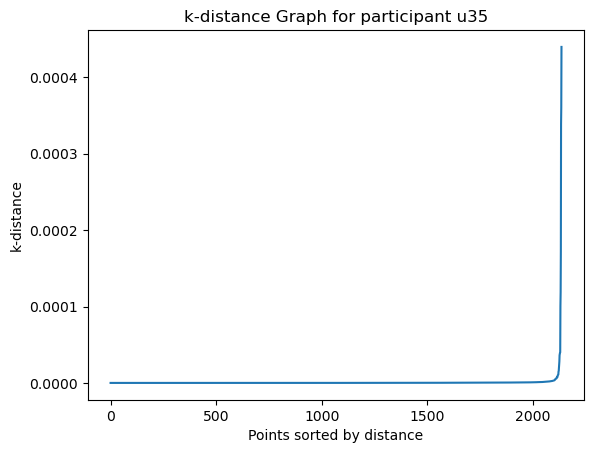

k-distance graph for participant u36


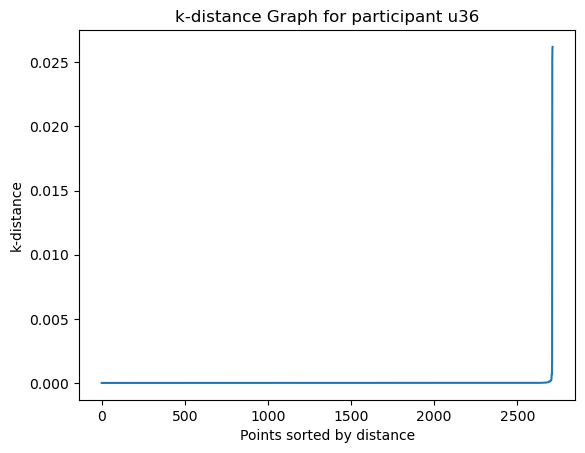

k-distance graph for participant u39


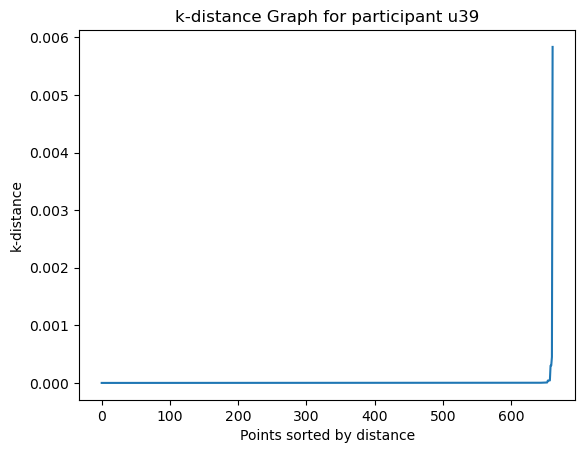

k-distance graph for participant u41


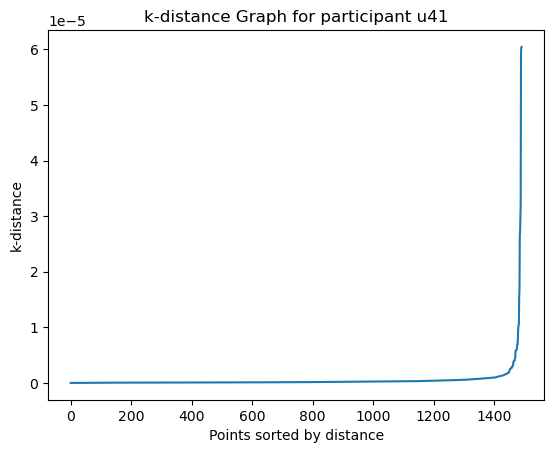

k-distance graph for participant u42


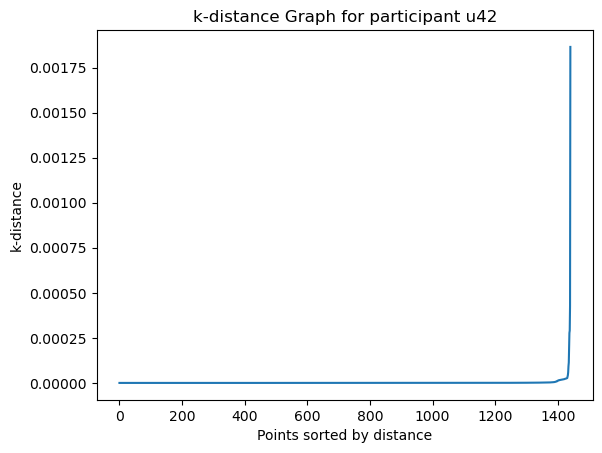

k-distance graph for participant u43


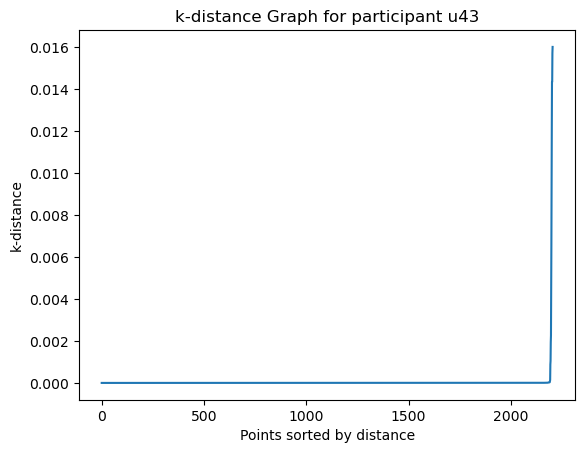

k-distance graph for participant u44


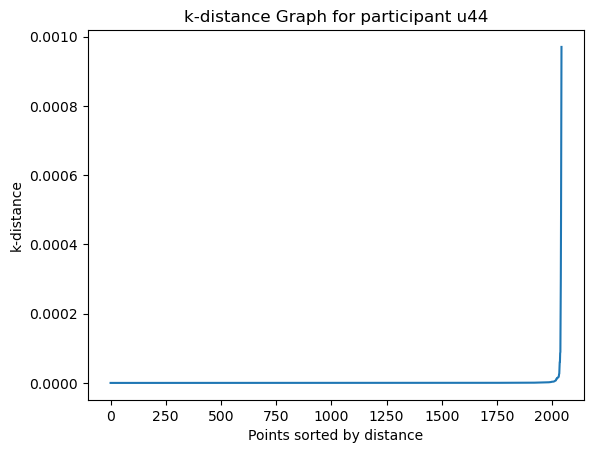

k-distance graph for participant u45


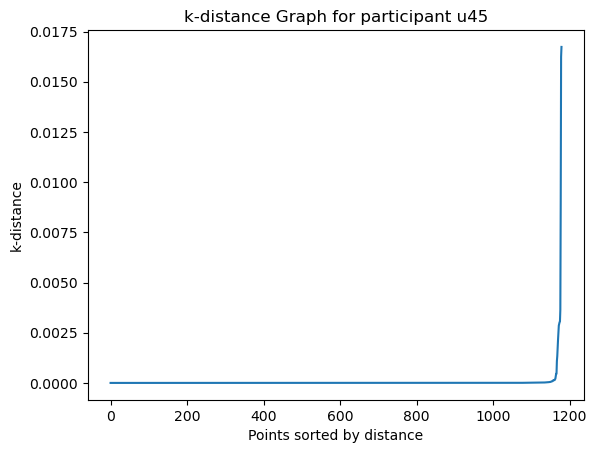

k-distance graph for participant u46


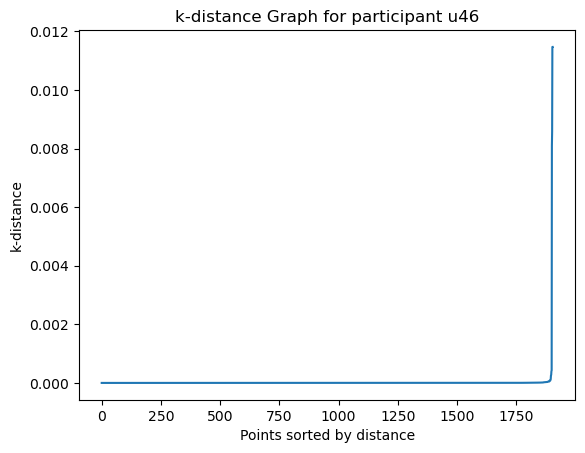

k-distance graph for participant u47


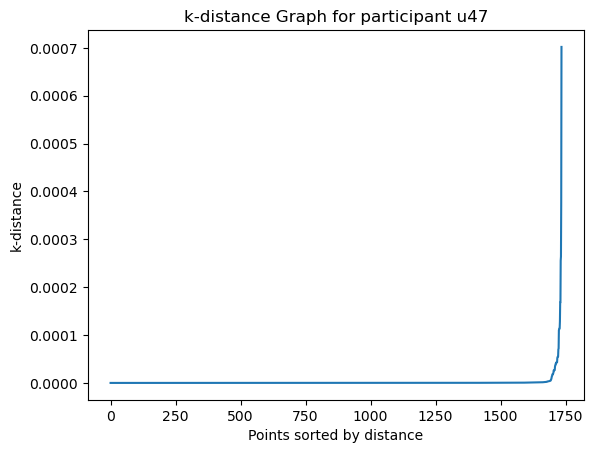

k-distance graph for participant u49


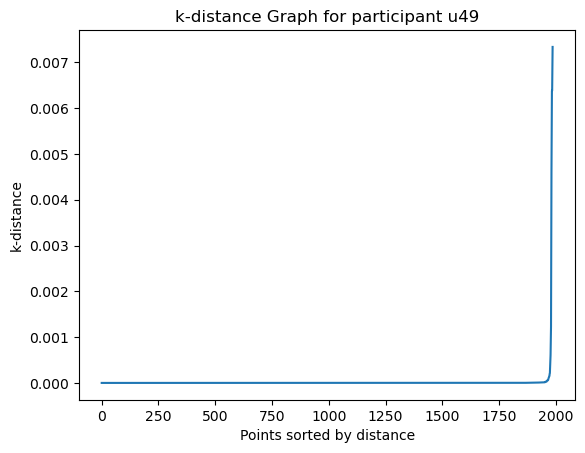

k-distance graph for participant u50


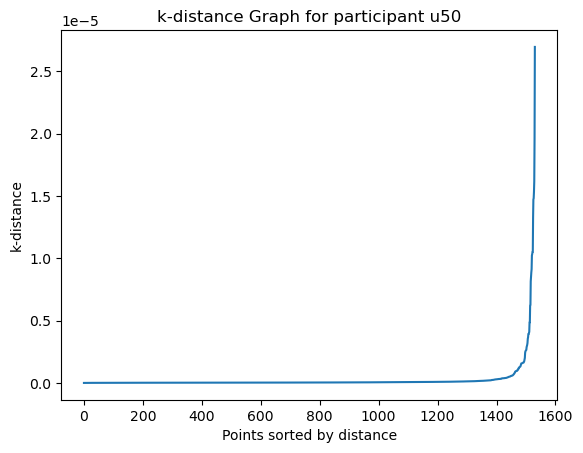

k-distance graph for participant u51


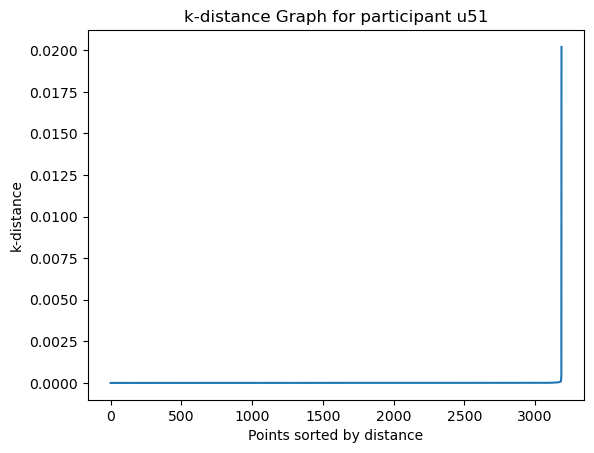

k-distance graph for participant u52


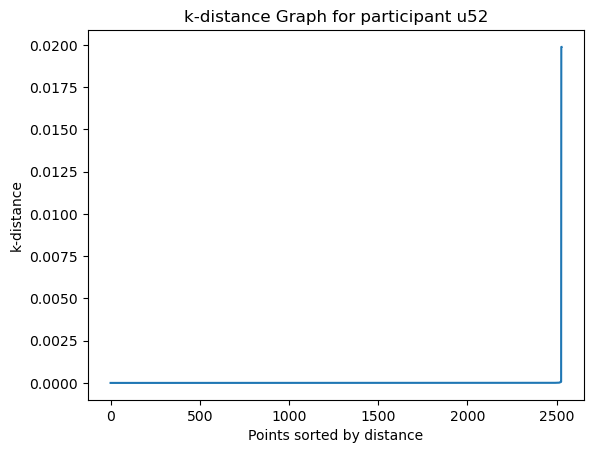

k-distance graph for participant u53


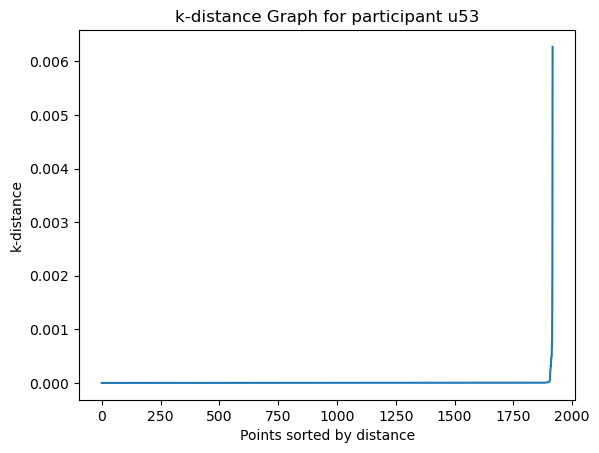

k-distance graph for participant u54


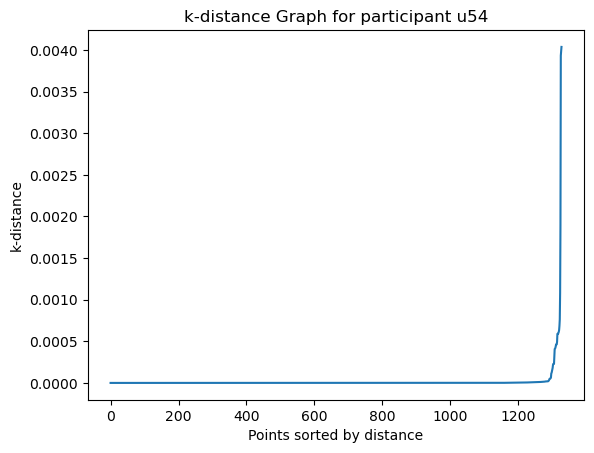

k-distance graph for participant u56


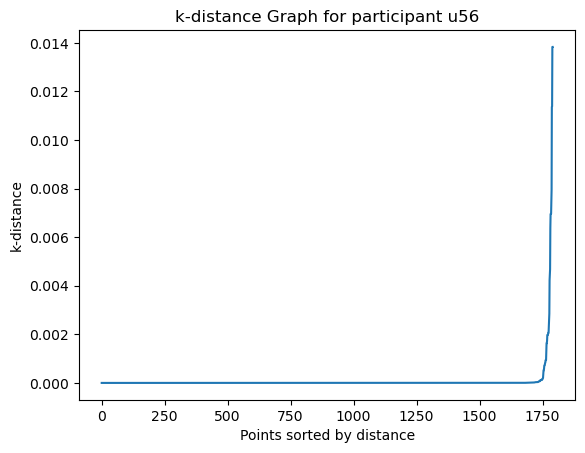

k-distance graph for participant u57


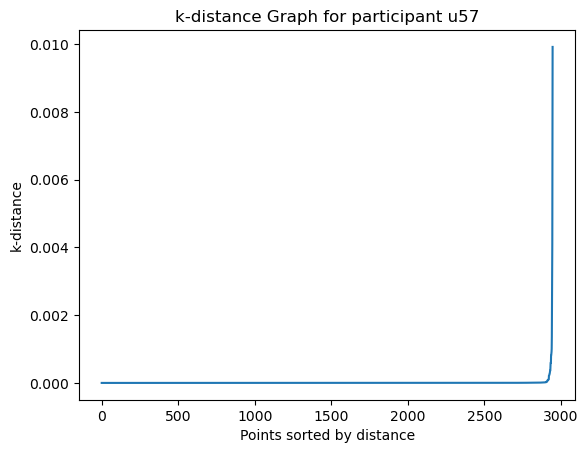

k-distance graph for participant u58


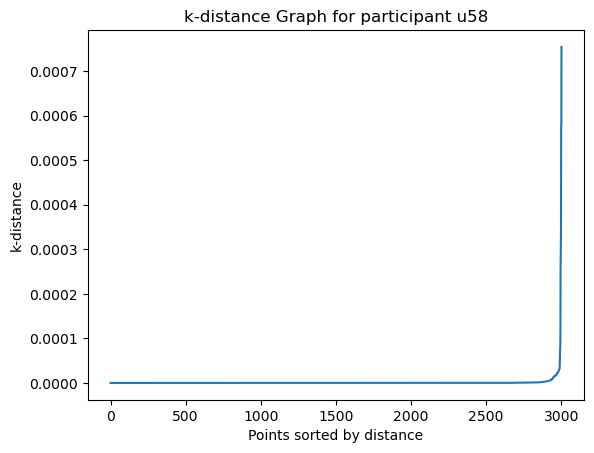

k-distance graph for participant u59


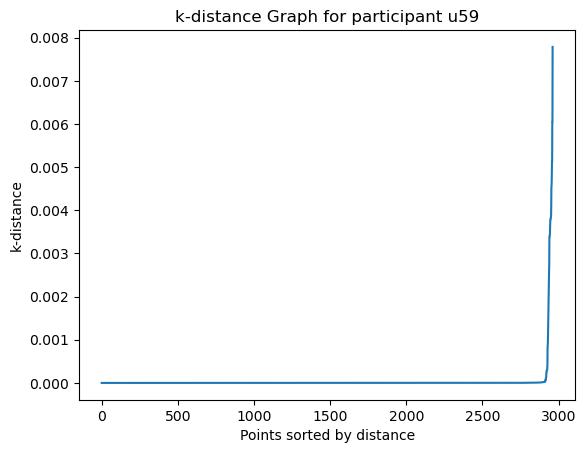

Optimal eps for participant u00: 0.002330288418059954
Optimal eps for participant u01: 1.2842394266789826e-05
Optimal eps for participant u02: 1.024763660741079e-05
Optimal eps for participant u03: 1.2126915643684773e-06
Optimal eps for participant u04: 0.05171324555084457
Optimal eps for participant u05: 2.6616871644062257e-05
Optimal eps for participant u07: 1.673857643770553e-05
Optimal eps for participant u08: 2.2526679061660385e-05
Optimal eps for participant u09: 1.7198649060116892e-05
Optimal eps for participant u10: 1.2531967806568357e-05
Optimal eps for participant u12: 0.001309998405590941
Optimal eps for participant u13: 7.054627715115649e-05
Optimal eps for participant u14: 9.310532005290072e-06
Optimal eps for participant u15: 2.7123797192873696e-05
Optimal eps for participant u16: 2.0658943041300595e-05
Optimal eps for participant u17: 7.505172537369722e-06
Optimal eps for participant u18: 2.0836480731853205e-05
Optimal eps for participant u19: 2.2803317129256586e-05
Opti

In [21]:
def compute_k_distance(df_, k):
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(df_)
    distances, indices = neighbors_fit.kneighbors(df_)
    distances = np.sort(distances[:, k-1], axis=0)
    return distances

# find the "elbow" point in the k-distance graph using kneed
def find_elbow_point(distances):
    kneedle = KneeLocator(range(1, len(distances) + 1), distances, curve="convex", direction="increasing")
    return kneedle.elbow_y

eps_values = {}

for participant in participants:
    participant_data = df_[df_['uid'] == participant][['latitude', 'longitude']].to_numpy()
    print(f'k-distance graph for participant {participant}')
    distances = compute_k_distance(participant_data, k=4)
    plt.plot(distances)
    plt.ylabel('k-distance')
    plt.xlabel('Points sorted by distance')
    plt.title(f'k-distance Graph for participant {participant}')
    plt.show()

    eps = find_elbow_point(distances)
    eps_values[participant] = eps

for participant, eps in eps_values.items():
    print(f'Optimal eps for participant {participant}: {eps}')

In [22]:
def find_clusters(data, eps, min_samples):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan.fit(data)
    labels = dbscan.labels_
    clusters = []
    unique_labels = set(labels)
    if -1 in unique_labels:
        unique_labels.remove(-1)  
    for label in unique_labels:
        cluster_indices = np.where(labels == label)[0]
        cluster = data.iloc[cluster_indices]
        clusters.append(cluster)
    return clusters, labels

def find_most_frequent_location(clusters):
    if not clusters:
        return None
    largest_cluster = max(clusters, key=len)
    most_frequent_location = largest_cluster.mean(axis=0)
    return most_frequent_location, largest_cluster.index

home_locations = {}
df_['home'] = 'not-home'

for participant in participants:
    participant_data = df_[df_['uid'] == participant]
    coordinates = participant_data[['latitude', 'longitude']]
    eps = eps_values[participant]
    min_samples = 3  # since GPS data is 2D, min_samples = 3 

    clusters, labels = find_clusters(coordinates, eps, min_samples)
    home_location, home_indices = find_most_frequent_location(clusters)
    home_locations[participant] = home_location

    # label each point in df_ as home or not-home
    df_.loc[home_indices, 'home'] = 'home'

    # propagate the labels from df_ back to the main DataFrame df
    df.loc[df_.index, 'home'] = df_['home']

for participant, home_location in home_locations.items():
    print(f'Home location for participant {participant}: {home_location}')

/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/194698908.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['home'] = 'not-home'


Home location for participant u00: latitude     0.763388
longitude   -1.262084
dtype: float64
Home location for participant u01: latitude     0.762815
longitude   -1.261681
dtype: float64
Home location for participant u02: latitude     0.762830
longitude   -1.261731
dtype: float64
Home location for participant u03: latitude     0.762801
longitude   -1.261579
dtype: float64
Home location for participant u04: latitude     0.762708
longitude   -1.261798
dtype: float64
Home location for participant u05: latitude     0.762790
longitude   -1.261698
dtype: float64
Home location for participant u07: latitude     0.762775
longitude   -1.261591
dtype: float64
Home location for participant u08: latitude     0.762791
longitude   -1.261668
dtype: float64
Home location for participant u09: latitude     0.762827
longitude   -1.261679
dtype: float64
Home location for participant u10: latitude     0.762779
longitude   -1.261621
dtype: float64
Home location for participant u12: latitude     0.761693
lon

In [23]:
home_locations
print(df['home'].value_counts())
print(df['home'].isnull().sum())

home        87060
not-home    14789
Name: home, dtype: int64
101028


In [24]:
for uid, home_coords in home_locations.items():
    mask = (
        (df['uid'] == uid) &
        (df['home'].isna()) &
        (np.isclose(df['latitude'], home_coords['latitude'], atol=1e-4)) &
        (np.isclose(df['longitude'], home_coords['longitude'], atol=1e-4))
    )
    df.loc[mask, 'home'] = 'home'

In [25]:
df = df[['uid', 'timestamp', 'date', 'home', 'time_interval']]
df.head(10)
df['uid'].unique()

array(['u00', 'u01', 'u02', 'u03', 'u04', 'u05', 'u07', 'u08', 'u09',
       'u10', 'u12', 'u13', 'u14', 'u15', 'u16', 'u17', 'u18', 'u19',
       'u20', 'u22', 'u23', 'u24', 'u25', 'u27', 'u30', 'u31', 'u32',
       'u33', 'u34', 'u35', 'u36', 'u39', 'u41', 'u42', 'u43', 'u44',
       'u45', 'u46', 'u47', 'u49', 'u50', 'u51', 'u52', 'u53', 'u54',
       'u56', 'u57', 'u58', 'u59'], dtype=object)

In [26]:
df.isnull().sum()
df['home'].fillna('not-home', inplace=True)

/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/948112856.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['home'].fillna('not-home', inplace=True)


In [27]:
df.head(3)

,uid,timestamp,date,home,time_interval
156575,u00,2013-03-27 04:02:43,2013-03-27,home,night
156576,u00,2013-03-27 04:22:24,2013-03-27,home,night
156577,u00,2013-03-27 04:42:44,2013-03-27,home,night


In [28]:
def calculate_home_time(uid, df_gps):
    user_df = df_gps[df_gps['uid'] == uid]
    columns = ['uid', 'date', 'home_stay_morning', 'home_stay_afternoon', 'home_stay_evening', 'home_stay_night', 
               'nothome_stay_morning', 'nothome_stay_afternoon', 'nothome_stay_evening', 'nothome_stay_night']
    result_df = pd.DataFrame(columns=columns)
    
    for date in user_df['date'].unique():
        date_df = user_df[user_df['date'] == date]
        
        home_stay = {
            'morning': 0,
            'afternoon': 0,
            'evening': 0,
            'night': 0
        }
        
        nothome_stay = {
            'morning': 0,
            'afternoon': 0,
            'evening': 0,
            'night': 0
        }
        
        grouped_by_interval = date_df.groupby('time_interval')
        
        for interval, interval_df in grouped_by_interval:
            interval_df = interval_df.sort_values(by='timestamp')
            
            previous_home = None
            previous_timestamp = None
            
            for index, row in interval_df.iterrows():
                current_home = row['home']
                current_timestamp = pd.to_datetime(row['timestamp'])
                
                if previous_timestamp is not None:
                    time_diff = (current_timestamp - previous_timestamp).total_seconds()
                    if previous_home == 'home':
                        home_stay[interval] += time_diff
                    else:
                        nothome_stay[interval] += time_diff
                else:
                    if current_home == 'home':
                        home_stay[interval] += 1  
                    else:
                        nothome_stay[interval] += 1
                
                previous_home = current_home
                previous_timestamp = current_timestamp

        result_df = result_df.append({
            'uid': uid,
            'date': date,
            'home_stay_morning': home_stay['morning'] / 3600,
            'home_stay_afternoon': home_stay['afternoon'] / 3600,
            'home_stay_evening': home_stay['evening'] / 3600,
            'home_stay_night': home_stay['night'] / 3600,
            'nothome_stay_morning': (6 * 3600 - home_stay['morning']) / 3600,
            'nothome_stay_afternoon': (5 * 3600 - home_stay['afternoon']) / 3600,
            'nothome_stay_evening': (4 * 3600 - home_stay['evening']) / 3600,
            'nothome_stay_night': (9 * 3600 - home_stay['night']) / 3600,
        }, ignore_index=True)

    return result_df

In [29]:
result_3 = DataFrame()

for uid in tqdm(student_uid):
    print(uid)
    df_ = calculate_home_time(uid, df)
    frames = [result_3, df_]
    result_3 = pd.concat(frames, ignore_index=True)

  0%|                                                    | 0/49 [00:00<?, ?it/s]/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future v

u00


/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

u01


/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

u02


/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


u03


/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


u04


/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

u05


/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

u07


/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

u08


/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

u09


/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

u10


/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

u12


/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

u13


/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

u14


/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

 29%|████████████▎                              | 14/49 [00:04<00:09,  3.55it/s]/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


u15
u16


/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

u17


/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

u18


/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

u19


/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

u20
u22


/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

u23


/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
 45%|███████████████████▎                       | 22/49 [00:06<00:06,  4.28it/s]

u24
u25


/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

 47%|████████████████████▏                      | 23/49 [00:06<00:05,  4.73it/s]/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future v

u27


/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

u30


/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

u31


/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

u32


/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

 57%|████████████████████████▌                  | 28/49 [00:08<00:05,  4.04it/s]

u33
u34


/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

 59%|█████████████████████████▍                 | 29/49 [00:08<00:04,  4.42it/s]/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future v

u35


/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
 61%|███████

/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

u36


/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
 65%|████████████████████████████               | 32/49 [00:09<00:03,  4.34it/s]/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future v

u39
u41


/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

u42


/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

u43


/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

u44


/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

u45
u46


/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

u47


/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
 80%|██████████████████████████████████▏        | 39/49 [00:10<00:02,  4.05it/s]/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future v

/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

u49


/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
 82%|███████████████████████████████████        | 40/49 [00:11<00:02,  3.94it/s]/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future v

/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

u50
u51


/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

u52


/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

u53


/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

u54
u56


/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

u57


/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

u58


/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

u59


/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders/k8/745_jm4x0n35zzr1p5chpdfh0000gn/T/ipykernel_57255/18358100.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
/var/folders

In [30]:
result_3['uid'].unique()
print(len(result_3))

2824


In [31]:
df = pivot_df.merge(pivot_df_, on=['uid', 'date'], how='inner').merge(result_3, on=['uid', 'date'], how='inner')
print(df.head(3))
print('-----------------------')
print(df.columns)

   uid        date  max_distance_afternoon  max_distance_evening  \
0  u00  2013-03-27                0.709984              7.902156   
1  u00  2013-03-28                0.615331              0.572584   
2  u00  2013-03-29                0.783514              0.658679   

   max_distance_morning  max_distance_night  mean_speed_afternoon  \
0             21.510659            0.044694              0.413447   
1             13.829300           21.510630              0.407571   
2              7.915113           21.510646              0.494983   

   mean_speed_evening  mean_speed_morning  mean_speed_night  ...  \
0            2.190630            8.615854          0.053758  ...   
1            0.162931           19.148841         11.210838  ...   
2           23.340963            5.434347         12.662640  ...   

   area_convex_hull_morning  area_convex_hull_night  home_stay_morning  \
0                 15.992131                0.012788           2.333611   
1                  0.000000  

In [32]:
print(df['home_stay_morning'].max())
print(df['home_stay_afternoon'].max())
print(df['home_stay_evening'].max())
print(df['home_stay_night'].max())

5.981111111111111
5.9911111111111115
5.990277777777778
5.993611111111111


In [33]:
df.to_csv('location_features_studentlife_last.csv')

In [34]:
print(len(df))

2824
